# Condensation and Coagulation
Homework 2 for the course Aerosols physics and chemistry

# Libraries

In [44]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyfluids import Fluid, FluidsList, Input

from scipy import constants as const

mpl.rcParams["figure.dpi"] = 100

# Global constants

In [45]:
h = const.Planck  # J s Planck constant
r_gas_c = const.R  # J/(mol K) molar gas constant 
k_boltz = const.Boltzmann  # J/K Boltzmann constant
g = const.g  # m/s^2 acceleration due to gravity
n_avo = const.Avogadro  # 1/mol Avogadro's number

# Function Definitions

In [46]:
# Default air standard properties
pressure_std = 101325 # Pa
temperature_std = 273.15 + 25 # K #??????? need to make sure this is the right temperature
air_std = Fluid(FluidsList.Air).with_state(Input.pressure(pressure_std), Input.temperature(temperature_std-273.15))


def c_cunningham(d_p, lamda = 65E-9):
    #defining the function
    #Cunningham correction factor
    #Dp is the particle diameter in meters
    #lamda is the mean free path of the gas in meters
    #C is the Cunningham correction factor
    kn = 2 * lamda / d_p
    return 1 + kn * (1.257 + 0.4 * np.exp(-1.1 / kn))
    

def mean_free_path(temperature, pressure):
# mean free path of air calculator
#T is the temperature in Kelvin
#P is the pressure in Pascals
#lamda is the mean free path of the gas in meters
    R = 8.314 # J/(mol K) gas constant
    M = 0.0289647 # kg/mol molar mass of air
    air = Fluid(FluidsList.Air).with_state(Input.pressure(pressure), Input.temperature(temperature - 273.15))
    viscosity = air.dynamic_viscosity # Pa s dynamic viscosity
    return 2 * viscosity / (pressure * np.sqrt(8 * M / (np.pi * R * temperature)))


def reynolds_number(d_p, velocity, fluid_density = air_std.density, dynamic_viscosity = air_std.dynamic_viscosity):
    #Reynolds number calculator
    #Dp is the particle diameter in meters
    #rho_f is the density of the fluid in kg/m^3
    #g is the acceleration due to gravity in m/s^2
    #C is the Cunningham correction factor
    #Re is the Reynolds number
    return (d_p * fluid_density * velocity) / dynamic_viscosity

def settling_velocity(d_p, rho_p, temperature, pressure):
    # Check if Dp_input is an array or a single value
    if np.isscalar(d_p):
        d_p_array = np.array([d_p])  # Convert to array for uniform processing
    else:
        d_p_array = d_p  # Use the array as is

    velocities = []  # Empty list to store calculated velocities
    for d_p in d_p_array:  # Process each Dp individually
        g = 9.81  # m/s^2
        l_mfp = mean_free_path(temperature, pressure)
        c_cun = c_cunningham(d_p, l_mfp)
        air = Fluid(FluidsList.Air).with_state(Input.pressure(pressure), Input.temperature(temperature - 273.15))
        mu_f = air.dynamic_viscosity
        rho_f = air.density
        s_velocity = c_cun * (rho_p * g * d_p**2) / (18 * mu_f)  # Stokes settling velocity
        Re = reynolds_number(d_p, s_velocity, fluid_density=rho_f, dynamic_viscosity=mu_f)
        if Re < 1:
            velocities.append(s_velocity)
        else:
            # Adjusted iterative approach for Re > 1, similar to before
            m_p = np.pi * rho_p * d_p**3 / 6
            for i in range(100):
                # c_d = 24 / Re * (1 + 0.15 * Re**(0.687))  # Updated drag coefficient expression
                c_d = 24 / Re * (1 + 3/16 * 0.43 * Re)
                # s_velocity = np.sqrt((4 * m_p * g) / (3 * np.pi * c_d * rho_f * Dp**2))
                s_velocity = np.sqrt((m_p * g) / (1/8 * np.pi * c_d * rho_f * d_p**2))
                Re_new = reynolds_number(d_p, s_velocity, fluid_density=rho_f, dynamic_viscosity=mu_f)
                if abs(Re_new - Re) < 0.01:
                    break  # Exit the loop if the change in Reynolds number is small enough
                else:
                    Re = Re_new
            velocities.append(s_velocity)

    velocities_array = np.array(velocities)  # Convert list to array

    if np.isscalar(d_p):
        return velocities_array[0]  # Return a single value if input was scalar
    else:
        return velocities_array  # Return array if input was array
    
def cond_dia_growth_rate(d_p, c_inf, c_sat, diff_coefficient, rho_p = 1E3):
    #condensation diameter growth rate
    #Dp is the particle diameter in meters
    b_factor = beta_corr_cond(d_p)
    d_dp_dt = b_factor * 4 * diff_coefficient * (c_inf - c_sat) / (rho_p * d_p)
    return d_dp_dt
    # # if np.isscalar(d_p):
    # #     d_p_array = np.array([d_p])  # Convert to array for uniform processing
    # # else:   
    # #     d_p_array = d_p  # Use the array as is
    # # dia_growth_rate = []  # Empty list to store calculated velocities
    # 
    # return dia_growth_rate

def cond_mass_growth_rate(d_p, c_inf, c_sat, diff_coefficient, rho_p = 1E3): 
    #condensation mass growth rate
    #Dp is the particle diameter in meters
    #c_inf is the concentration of the condensing vapor in the bulk gas in molec/m^3
    #c_sat is the saturation concentration of the condensing vapor in molec/m^3
    #diff_coefficient is the diffusion coefficient of the condensing vapor in m^2/s
    #rho_p is the density of the particle in kg/m^3 (default is 1E3 kg/m^3)
    #m_p is the mass of the particle in kg
    #particle mass
    m_p = np.pi * rho_p * d_p**3 / 6
    #mass growth rate
    
    return m_p * cond_dia_growth_rate(d_p, c_inf, c_sat, diff_coefficient)

def beta_corr_cond(d_p, lamda = 65E-9):
    #Dahneke correction factor
    #Dp is the particle diameter in meters
    #B is the Darkener correction factor
    # kn is the Knudsen number
    # lamda is the mean free path of the gas in meters
    kn = 2 * lamda / d_p
    b_factor = (1 + kn) / (1 + 2 * kn * (1 + kn))
    return b_factor


def unit_conversion(conversion, variable=1):
    switcher = {
        #length
        'cm3_to_m3': variable * 1E-6,
        'm3_to_cm3': variable * 1E6,
        #time
        'hr_to_s': variable * 3600,
        's_to_hr': variable * 1/3600,
        #volume
        'm3_to_L': variable * 1000,
        'L_to_m3': variable * 1/1000,
        #mass
        'kg_to_g': variable * 1000,
        'g_to_kg': variable * 1/1000,
        #pressure
        'Pa_to_kPa': variable * 1E-3,
        'kPa_to_Pa': variable * 1E3,
        'atm_to_Pa': variable * 101325,
        'Pa_to_atm': variable * 1/101325,
        #temperature
        'C_to_K': variable + 273.15,
        'K_to_C': variable - 273.15,
    }
    return switcher.get(conversion, 'Invalid conversion')

def dp_to_mp_distribution(d_p, rho_p = 1E3):
    #Dp is the particle diameter in meters
    #rho_p is the density of the particle in kg/m^3
    #m_p is the mass of the particle in kg
    m_p = np.pi * rho_p * d_p**3 / 6
    return m_p



# Other Functions - Coagulation

In [ ]:
def k_coag(dp_1, dp_2, d_diff1, d_diff2, temp = temperature_std, rho_1 = 1000, rho_2 = 1000): #
    
    # Source: Sienfeld, J. H., & Pandis, S. N. (2006). Atmospheric chemistry and physics: from air pollution to climate change. John Wiley & Sons.
    # 2nd Edition Table 13.1
    #coagulation coefficient
    #Dp1 is the diameter of particle 1 in meters
    #Dp2 is the diameter of particle 2 in meters
    #c1 is the concentration of particle 1 in molec/m^3
    #c2 is the concentration of particle 2 in molec/m^3
    #d_diff1 is the diffusion coefficient of particle 1 in m^2/s
    #d_diff2 is the diffusion coefficient of particle 2 in m^2/s
    #temp is the temperature in Kelvin
    #rho_1 is the density of particle 1 in kg/m^3
    #rho_2 is the density of particle 2 in kg/m^3
    # k_bolt is the Boltzmann constant in J/K defined in the global constants
    

    #k is the coagulation coefficient
    m_1 = rho_1 * np.pi / 6 * dp_1 * 3 # mass of one particle in kg
    m_2 = rho_2 * np.pi / 6 * dp_2 * 3 # mass of one particle in kg
    c_1 = np.sqrt(8 * k_boltz * temp / (np.pi * molar_mass))
    l_1 = 8 * d_diff1 / (np.pi * c_1)
    l_2 = 8 * d_diff2 / (np.pi * c_1)
    g_1 = 1 / (3 * dp_1 * l_1) * ((dp_1 + l_1) ** 3 - (dp_1 ** 2 + l_1 ** 2) ** (3 / 2)) - dp_1
    g_2 = 1 / (3 * dp_2 * l_2) * ((dp_2 + l_2) ** 3 - (dp_2 ** 2 + l_2 ** 2) ** (3 / 2)) - dp_2
    denominator = (((dp_1 + dp_2) / (dp_1+dp_2+2*np.sqrt(g_1**2+g_2**2))) + 8*(d_diff1+ d_diff2)/(c_1**2+c_2**2)**0.5 / (dp_1+dp_2))
    
    k_coag_fuchs = 2 * np.pi * (dp_1 + dp_2) * (d_diff1 + d_diff2) / denominator
                  # rest of the equation
                  
    return k_coag_fuchs

# Bins definition

In [22]:
#defining the bins
bin_number = 40
bins_lower = np.geomspace(1e-9, 10.3e-6, bin_number + 1)  #
bins_upper = bins_lower[1:]
bins_lower = bins_lower[:-1]
bins_g_mean = np.sqrt(bins_lower * bins_upper)  # geometric mean
bins_g_mean_mass = dp_to_mp_distribution(bins_g_mean)

# Problem 1
Condensation of Sulfuric Acid (H2SO4) 

In [36]:
# reaction rate of H2SO4 with water
# H2SO4 + H2O -> H3O+ + HSO4-
# k = 5E-7 cm^3/molec s 
x = 2 #m^3
x_cm_3 = unit_conversion(x, 'm3_to_cm3')
print(x_cm_3)

2000000.0


In [24]:
c_inf_h2so4 = 5E7 / const.centi ** 3 #molec/m^3
c_sat_h2so4 = 0 #molec/m^3
diff_h2so4 = 1E-5 #m^2/s


In [25]:
dp_dt_cond = cond_dia_growth_rate(bins_g_mean, c_inf_h2so4, c_sat_h2so4, diff_h2so4, rho_p = 1E3)

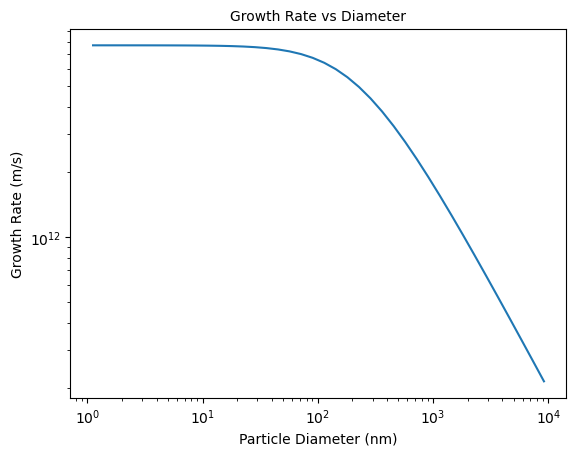

In [26]:
# plot growth rate vs diameter
fig, ax = plt.subplots()
ax.plot(bins_g_mean / const.nano , dp_dt_cond)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Particle Diameter (nm)')
ax.set_ylabel('Growth Rate (m/s)')
ax.set_title('Growth Rate vs Diameter')
# change the font
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.show()



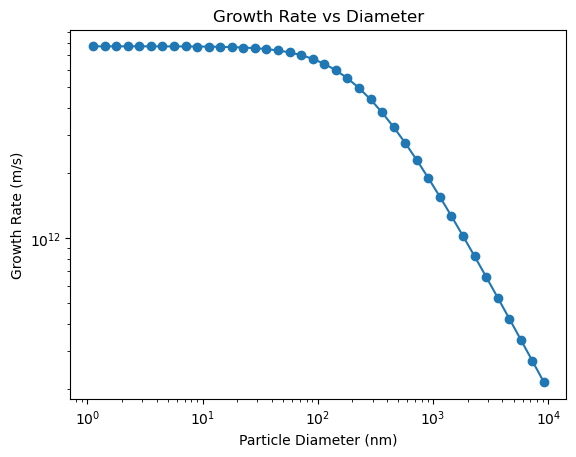

In [27]:
# plot growth rate vs diameter
fig, ax = plt.subplots()
ax.plot(bins_g_mean / const.nano , dp_dt_cond)
ax.scatter(bins_g_mean / const.nano , dp_dt_cond)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Particle Diameter (nm)')
ax.set_ylabel('Growth Rate (m/s)')
ax.set_title('Growth Rate vs Diameter')
plt.show()


# Problem 1-part b

In [28]:
#mass growth rate
mass_growth_rate = cond_mass_growth_rate(bins_g_mean, c_inf_h2so4, c_sat_h2so4, diff_h2so4, rho_p = 1E3)


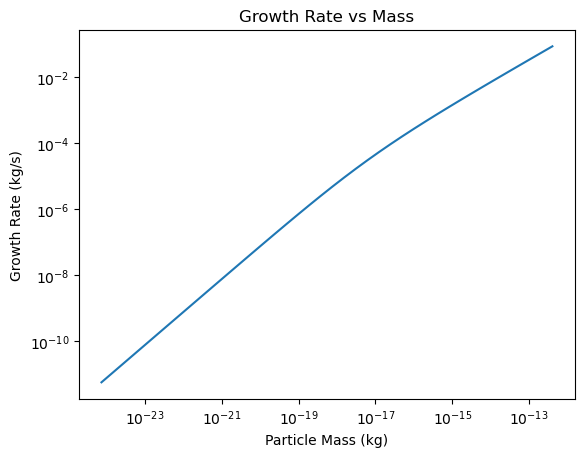

In [40]:
# plot mass growth rate vs particle mass
fig, ax = plt.subplots()
ax.plot(bins_g_mean_mass, mass_growth_rate)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Particle Mass (kg)')
ax.set_ylabel('Growth Rate (kg/s)')
ax.set_title('Growth Rate vs Mass')
plt.show()

# Problem 2
Coagulation as a growth mechanism


In [30]:
N1 = 3000 / const.centi ** 3 #molec/m^3
dp1 = 10 * const.nano #m
N2 = 400 / const.centi ** 3 #molec/m^3
dp2 = 100 * const.nano #m